# Election Tweets: Geolocation

To understand just how real the "red state/blue state" divide is on the tweet level, I need some geolocation data. Since only very few users (<2%) activate the geotagging feature on their user accounts, I'll need to get this information from other sources. I decided to extract this info from people's self-reported location (in their user profile), but now I want to see what the data looks like and what information I can extract to put towards modelling.

In [473]:
import re
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib as plt

import warnings
warnings.filterwarnings('ignore')

In [506]:
tweets = pd.read_csv('./tweet_newsentiment.csv')

## Step 1: Understanding geolocation by numbers

Some introductory questions:
- How many tweets have geotagged location vs. location based on profile info?
- Any differences by Republican/Democrat ticket?

### Geotagged vs. profile geolocation

Some basic cleanup is necessary as some of these locations were generated in development versions of the tweet streaming script.

In [343]:
loc_no = pd.DataFrame(tweets.groupby(['loc_type', 'ticket']).count()['tweet_id']).unstack()

In [344]:
keep_rows = ['bound_box_coords', 'no_loc', 'user_loc', 'geo_loc']
drop_rows = [column for column in loc_no.index.values if column not in keep_rows]

In [345]:
loc_no = loc_no.drop(drop_rows, axis=0)
loc_no = pd.DataFrame(loc_no.to_records())
loc_no.columns = ['loc_type', 'Democrat', 'Republican']
loc_no['total'] = loc_no['Democrat'] + loc_no['Republican']

In [346]:
def get_ticket_percent(data, ticket):
    colname_total = f'percent_of_total_{ticket}'
    colname_ticket = f'percent_of_ticket_{ticket}'
    data[colname_total] = data[ticket].apply(lambda x: round((x/sum(data['total']))*100, 2))
    data[colname_ticket] = data[ticket].apply(lambda x: round((x/sum(data[ticket]))*100, 2))
    return data

In [347]:
tickets = ['Democrat', 'Republican']

for ticket in tickets:
    loc_no = get_ticket_percent(loc_no, ticket)

In [348]:
loc_no['total_percent'] = loc_no['total'].apply(lambda x: round((x/sum(loc_no['total']))*100, 2))

In [349]:
loc_no

,loc_type,Democrat,Republican,total,percent_of_total_Democrat,percent_of_ticket_Democrat,percent_of_total_Republican,percent_of_ticket_Republican,total_percent
0,bound_box_coords,851.0,401.0,1252.0,0.27,0.45,0.13,0.31,0.40
1,geo_loc,12.0,3.0,15.0,0.00,0.01,0.00,0.00,0.00
2,no_loc,78283.0,50747.0,129030.0,24.75,41.52,16.04,39.70,40.79
3,user_loc,109381.0,76660.0,186041.0,34.58,58.02,24.23,59.98,58.81


#### Conclusions

1. Less than half a percent of this tweet database has 'ground-truth' geotagged location data.
2. 40% has no location at all.
3. But between geotagging and user profile location data, we still have close to 60% of the dataset available.
4. Initially it looks like there's a partisan divide in terms of people's provision of geolocation data (looking at the `percent_of_total` columns). However, breaking it down into percent by ticket suggests that there isn't an enormous contrast between the two populations after all, this is just an artefact of there being slightly more Democrat than Republican tweets overall. (Could determine further statistical information concerning probability of having a location based on ticket using a logistic regression here but it doesn't seem interesting enough to warrant the extra attention.)

## Step 2: Quality check

I used the `geocoder` package to get over 42k locations based on people's user profiles. While some folks' self-reported location is plausible ("Milwaukee-Chicago"), other locations are less straightforward to map onto real-world locations ("Marvel Universe", "hell since 2016", "God's Country", "Always butter the Pan"). What did `geocoder` make of these less plausible locations?

How to check: Sample 1000 locations and manually check. (I want a GUI for this and am doing it in good old Excel.)
- What proportion of these is a joke location? This will help us get a sense of the amount of noise in the data.
- What does `geocoder` make of the joke locations?

In [164]:
list_locs = list(tweets['location'].unique())
len(list_locs)

45219

In [324]:
# separate out just the tweets that have a profile-based location

loc_tweets = tweets[tweets['loc_type'] == 'user_loc']

In [326]:
loc_sample = loc_tweets.sample(n=1000)

In [328]:
loc_sample = loc_sample.drop([column for column in loc_sample.columns if column not in ['location', 'loc_type', 'us_state', 'loc_lat', 'loc_lon']], axis=1)
loc_sample.to_csv('./location_random_sample.csv', index=False)

**Manual data annotation of random sample:**

1. Binary manual classification into feature `unclear_loc` (0, 1). Some examples of `unclear_loc == 1` in this particular sample:
    - a `location: Right now? Arkansas`
    - b `Earth`
    - c `In Trump's Nightmares`
    - d `COviNGTON va BAbY!!!!`
    - e `Nicht Bielefeld`
    - f `None of your business`
    - g `NoVa`
    - h `The Dirty South-GA`
2. Binary manual classification into feature `implausible_assigned_loc` (0, 1). My highly subjective criteria were:
    - `implausible_assigned_loc == 0`: if `geocoder` managed to get correct information out of an unclear location (e.g. assigning location `Arkansas` to example a, `Virginia` to example d), or classifies it as `other` (e.g. assigning `other` to example e).
    - `implausible_assigned_loc == 1`: odder assignments get a rating of 1, e.g. assigning location b to Texas, c to Maryland, f to Washington, or g to Ohio ("NoVa" is short for Northern Virginia), or failing to get location information where technically present (e.g. assigning `other` to example h).
    
**Next up:** let's get a sense of the scale of the noise.
1. What percentage of locations are unclear?
2. Of these, what percentage are implausible and therefore likely erroneous?
3. What's the likely percentage of erroneous assignments overall?

**Update:** adding 2nd sample for higher accuracy.

In [329]:
loc_sample_annotated1 = pd.read_csv('./location_random_sample_13012021.csv')
loc_sample_annotated2 = pd.read_csv('./location_random_sample_withhashtags_14012021.csv')

In [332]:
loc_sample_annotated1['hashtags'] = np.nan

In [334]:
loc_sample_annotated = pd.concat([loc_sample_annotated1, loc_sample_annotated2], axis=0)

In [336]:
percent_unclear = (sum(loc_sample_annotated['unclear_loc'])/len(loc_sample_annotated))*100
percent_unclear

19.6

In [337]:
percent_implausible = (sum(loc_sample_annotated['implausible_assigned_loc'])/len(loc_sample_annotated[loc_sample_annotated['unclear_loc'] == 1]))*100
percent_implausible

40.816326530612244

In [338]:
percent_erroneous_total = (sum(loc_sample_annotated['implausible_assigned_loc'])/len(loc_sample_annotated))*100
percent_erroneous_total

8.0

#### Conclusions from manual data quality check

In this sample, nearly one-fifth of locations were unclear; 40% of those were not assigned a correct location by `geocoder`. Overall, this results in an 8% rate of poor location information.

On the flip side, that's over 90% accuracy in `geocoder`'s ability to detect a user's location!

**How can we use this to predict location for tweets that didn't include user location?**

Options from various domains (which could also help impute missing location data for the users who provided none at all):

1. **Hashtag tracking:** If the tweet contains a hashtag, in which state is this hashtag most popular?
    - Given a particular hashtag, what's the likelihood of it being tweeted from a specific state? Or at a somewhat zoomed out level, from a red or blue state (rather than the exact state)?
    - Predict the state from hashtags?
        - This is somewhat risky, as the model will be learning from data whose labelling is only 92% accurate.
        - To avoid the problems with poorly annotated data: Are there enough geotagged tweets containing hashtags in order to build a  model restricted to just this data subset, and then extrapolate from there to the wider dataset?
            - Can we augment this data set through human-annotated reference samples?
        - Otherwise: If we accept the 8% noise factor, can we build a more robust model using all of the location data we have (from either geotagging or user profile info) and use it to extrapolate to tweets that didn't have a user location?
        - Note: Some subset of the data that contains no location information also does not contain hashtags. How much data will be left unlabelled through this approach?
    
2. **Social network clustering:** Can we interpolate a user's location from the people they follow and their locations?
    - The dataset contains tweets from >220k unique users
    - Steps would be:
        - Grab user's followed accounts (Twitter API limits this to 5k followers at a time, this seems like more than enough)
        - Get those users' locations where possible (this will have the same problem with noise in self-reported locations)
        - Interpolation: copy location of the account that a user most frequently interacts with? Does Twitter provide this data in some summary form? If so, is the location of a high-interaction account actually a good proxy for a user's location? (Boils down to: do people interact more with people who live close to them? Probably some do and some don't.)
        
        
Given the issues with Twitter API limits, I'm going to try hashtag tracking first.

## Step 3: Location Interpolation Using Hashtags

Logic/assumptions for this interpolation model:

1. Sentiment is correlated with geolocation.
    - Pro-Trump hashtagged tweets are likely to come from pro-Trump states.
2. Hashtags are correlated with partisan sentiment.
    - Hashtags were stripped out of tweets before sentiment analysis, so there's no risk of a confound.
    - E.g. pro-Trump partisan tweets (= high sentiment, about Trump) are likely to be clustered around certain hashtags.
3. Therefore, hashtag predicts location.


Building the model:
- Training and testing the model: I'll use the ground-truthed data that I have from the geotagged tweets. Since this is an extremely small data set, I'll augment with a fresh batch of human-annotated data.
- Model type: LogReg classifier that predicts red state/blue state/lean red/lean blue based on hashtag feature
- Geolocation based on user profile was over 90% accurate. If I can build a model that reaches 80% accuracy of predicting location from hashtags, I'll be happy.
    - Lower threshold chosen because of the Poisson distribution in hashtag frequency, meaning that while some hashtags will have high degree of correlation with location (e.g. #StopTheSteal) less frequent ones will be noisier.

### Checking assumption 1: Does partisanship correlate with location?

Definition of partisanship for the purposes of this analysis:
- If a tweet's sentiment is above the average daily score for tweets about a particular ticket, it is pro that ticket. If it's below the average, it's anti that ticket.
    - Example: a tweet about Donald Trump that has a sentiment of 0.7 on a day when the average sentiment of Trump-related tweets is 0.2 has a partisan lean of 0.5 in Trump's favour.
- This is essentially within-group normalisation.

Location partisanship:
- I'm going to add data from the 2020 election highlighting who won each state and by how much.

#### Partisanship & Normalisation

Start by checking distribution of sentiment.

In [350]:
dem = tweets[tweets['ticket']=='Democrat']
rep = tweets[tweets['ticket']=='Republican']

In [351]:
dem_sent = dem['sentiment']
rep_sent = rep['sentiment']

In [355]:
print(dem_sent.mean(), rep_sent.mean())

0.08297533965880474 0.004220808850566574


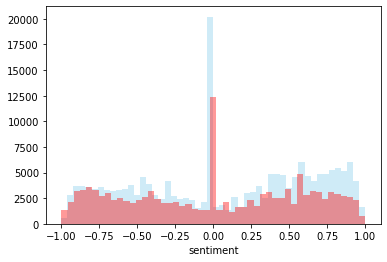

In [354]:
sns.distplot(dem_sent, color='skyblue', kde=False)
sns.distplot(rep_sent, color='red', kde=False)

**Upshot of distribution check:**

Looks like the sentiment is distributed fairly evenly across the two tickets. This makes sense, as there are likely to be roughly equal numbers of pro and anti Republican/Democrat tweets.

Normalising within daily means: let's see what the distributions show now.

Interpreting the new `partisan_lean` feature:
- the more positive the value, the more pro-that particular ticket
- so this is a measure of partisanship.

In [507]:
tweets['dailymeansentiment'] = tweets.groupby(['ticket', 'date'])['sentiment_2'].transform('mean')

In [508]:
tweets['partisan_lean'] = tweets['sentiment_2'] - tweets['dailymeansentiment']

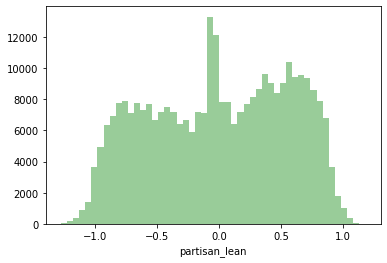

In [509]:
# plot distribution of partisan lean

sns.distplot(tweets['partisan_lean'], color='green', kde=False)

**Upshot:**

We're getting a bimodal distribution with a huge spike of neutrals (due to the large number of tweets rated 0).

Now let's check if there's some correlation of partisanship and location.

#### Add election outcome data

We'll use this to sort states into red, blue, lean red and lean blue categories, where:

- A vote margin of <10% results in a "lean" classification
- A vote margin of >10% results in a "red/blue" classification

In [496]:
election_url = 'https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv'

election_counties = pd.read_csv(election_url)

In [497]:
election_counties.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [498]:
election_states = election_counties.groupby('state_name')[['total_votes', 'votes_gop', 'votes_dem']].sum().reset_index()

In [499]:
# calculate vote margins within each state based on total vote numbers.

election_states['per_gop'] = election_states['votes_gop']/election_states['total_votes']
election_states['per_dem'] = election_states['votes_dem']/election_states['total_votes']
election_states['per_point_diff'] = election_states['per_gop'] - election_states['per_dem']

In [500]:
state_types = ['blue', 'lean_blue', 'lean_red', 'red']

In [501]:
election_states['redblue'] = pd.cut(election_states['per_point_diff'], bins=[-1, -0.1, 0, 0.1, 1], include_lowest=True, labels=state_types)

In [502]:
election_states

,state_name,total_votes,votes_gop,votes_dem,per_gop,per_dem,per_point_diff,redblue
0,Alabama,2323304,1441168,849648,0.620310,0.365707,0.254603,red
1,Alaska,391346,189892,153405,0.485228,0.391993,0.093235,lean_red
2,Arizona,3387326,1661686,1672143,0.490560,0.493647,-0.003087,lean_blue
3,Arkansas,1219069,760647,423932,0.623957,0.347751,0.276207,red
4,California,17495906,6005961,11109764,0.343278,0.634992,-0.291714,blue
5,Colorado,3256953,1364607,1804352,0.418983,0.554000,-0.135017,blue
6,Connecticut,1824280,715291,1080680,0.392095,0.592387,-0.200292,blue
7,Delaware,504010,200603,296268,0.398014,0.587822,-0.189808,blue
8,District of Columbia,344356,18586,317323,0.053973,0.921497,-0.867524,blue
9,Florida,11067456,5668731,5297045,0.512198,0.478615,0.033584,lean_red


In [503]:
state_categories = election_states[['state_name', 'redblue']]

In [504]:
none_row = pd.DataFrame([['other', 'none'], ['no_loc', 'none']], columns=['state_name', 'redblue'])

In [513]:
state_categories = state_categories.append(none_row, ignore_index=True)
state_categories.columns = ['us_state', 'redblue']
state_categories.tail()

,us_state,redblue
48,West Virginia,red
49,Wisconsin,lean_blue
50,Wyoming,red
51,other,none
52,no_loc,none


In [514]:
tweets = pd.merge(state_categories, tweets, on='us_state')

#### Check distribution of sentiment within each state type

In [515]:
# separate out by ticket so that we can see if partisanship and location line up by ticket.

dem = tweets[tweets['ticket'] == 'Democrat']
rep = tweets[tweets['ticket'] == 'Republican']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14554de10>,
      dtype=object)

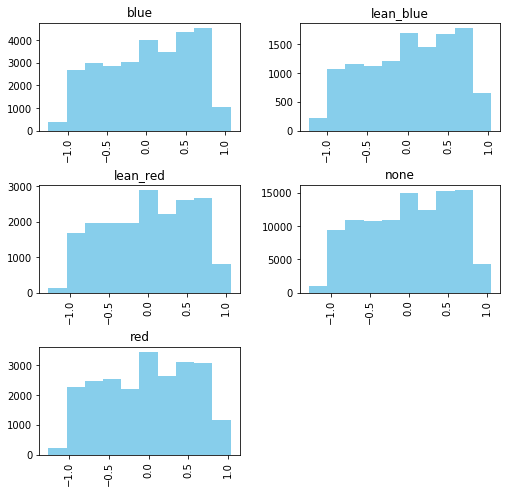

In [518]:
dem['partisan_lean'].hist(by=dem['redblue'], figsize=[8, 8], color='skyblue')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1431a3f50>,
      dtype=object)

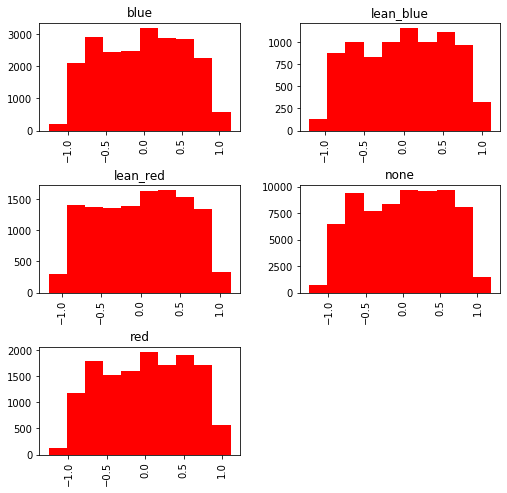

In [521]:
rep['partisan_lean'].hist(by=rep['redblue'], figsize=[8, 8], color='red')

In [482]:
for state in state_types:
    mean = tweets[tweets['redblue'] == state]['partisan_lean'].mean()
    median = tweets[tweets['redblue'] == state]['partisan_lean'].median()
    print(state, ': ', mean, ', ', median)

blue :  0.003962183536801198 ,  0.014404912536443326
lean_blue :  0.01424427763860737 ,  0.02176475515463941
lean_red :  -0.0035643145600202444 ,  -0.0014650694777191397
red :  -0.015504682578789578 ,  -0.00619839698255549


Interesting! We're seeing a similar distribution across all state types: a slight preponderance of more partisan tweets, but overall a mostly uniform distribution.

This is unexpected, as we would have thought that Trump-related tweets form a 

(Note: y axes are not the same across all plots. That doesn't matter in this case because we're interested in the distribution, rather than the actual numbers.)

### Create dataset for location interpolation

In [201]:
def get_handles_hashtags(text):
    '''
    Returns separate lists of hashtags and user handles in the text
    '''
    handles = re.findall('\B\@\w+', text)
    hashtags = re.findall('\B\#\w+', text)
    return handles, hashtags

In [203]:
tweets[['handles', 'hashtags']] = tweets.apply(lambda row: pd.Series(get_handles_hashtags(row['text'])), axis=1)

In [226]:
# saving for later

tweets.to_csv('./tweets_loc_with_hashtags.csv', index=False)

#### Extract geotagged tweets that also contain hashtags

In [223]:
# Among the geotagged tweets, how many actually contain hashtags at all?

geotag_tweets = tweets[tweets['loc_type'] == 'bound_box_coords']

In [255]:
geotag_tweets['hashtags_present'] = [x if x != [] else np.nan for x in geotag_tweets['hashtags']]

In [260]:
geotag_hashtags = geotag_tweets.dropna()
len(geotag_hashtags)

374

In [ ]:
# add new human-annotated dataset

In [264]:
geotag_hashtags = geotag_hashtags[['us_state', 'hashtags']]
geotag_hashtags

,us_state,hashtags
5257,other,"[#JoeBiden, #1994crimebill]"
5501,Virginia,[#Trump2020]
6968,other,"[#YouAndMeBoth, #BadAssWomen, #Vote, #VoteEarl..."
10115,Texas,"[#Trump, #COVID, #GetWellSoon]"
11300,other,[#COVID19]
...,...,...
313290,other,"[#bullshitboy, #ScottyFromMarketing, #climatec..."
313759,South Carolina,"[#GeorgeBush, #Constitution]"
313866,Colorado,[#Election2020]
314238,Massachusetts,[#BOSTON2024]


In [267]:
long_geotags = pd.DataFrame()

In [306]:
for index, row in geotag_hashtags.iterrows():
    states = pd.Series([row['us_state']]*len(row['hashtags']), name='state')
    hashtags = pd.Series(row['hashtags'], name='hashtags')
    new = pd.concat([states, hashtags], axis=1)
    long_geotags = pd.concat([long_geotags, new])

long_geotags = long_geotags.reset_index(drop=True)

In [309]:
len(long_geotags)

6545

In [313]:
long_geotags['hashtags'].nunique()

786

In [316]:
long_geotags['state'].nunique()

41

In [319]:
state_geo_count = long_geotags.groupby('state').count()
state_geo_count

,hashtags
state,
Alabama,15
Arizona,120
Arkansas,50
California,600
Colorado,55
Connecticut,50
Delaware,20
Florida,460
Georgia,240
